# 🚀 Project: Optimasi Stok Akhir Tahun & Analisis Anomali Holiday

Latar Belakang: Awalnya, data menunjukkan lonjakan penjualan ekstrem yang dicurigai sebagai outlier. Namun, analisis mendalam membuktikan bahwa menghapus data ini akan menghilangkan revenue terbesar perusahaan. Project ini bertujuan memperbaiki strategi stok dengan menganalisis perilaku belanja musiman dan distribusi performa toko.

---

## 1. Persiapan Data & Mapping Event
Kita mulai dengan memecah label "Holiday" yang umum menjadi event spesifik untuk melihat dampaknya masing-masing.

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ticker

import seaborn as sns

import os

In [2]:
# Setup Directory Paths
current_dir = os.getcwd()
project_root = os.path.dirname(os.path.dirname(current_dir)) 
processed_path = os.path.join(project_root, 'data', 'walmart', 'processed', 'walmart_clean.csv')

# Load Data
df = pd.read_csv(processed_path, parse_dates=['Date'])

print(f"✅ Data Siap Analisis! Dimensi: {df.shape}")
display(df.head(3))

# Pastikan format tanggal benar
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Sesuaikan dayfirst jika perlu

# Fungsi untuk memetakan tanggal ke Event Liburan spesifik
# def get_holiday_type(row):
#     if row['Holiday_Flag'] == 0:
#         return 'Regular Week'
    
#     # Ambil tanggal sebagai string
#     d = row['Date'].strftime('%d-%m-%Y')
    
#     # Mapping tanggal (Contoh berdasarkan data 2010-2012)
#     super_bowl = ['12-02-2010', '11-02-2011', '10-02-2012']
#     labor_day  = ['10-09-2010', '09-09-2011', '07-09-2012']
#     thanksgiving = ['26-11-2010', '25-11-2011', '23-11-2012']
#     christmas = ['31-12-2010', '30-12-2011', '28-12-2012']
    
#     if d in super_bowl: return 'Super Bowl'
#     elif d in labor_day: return 'Labor Day'
#     elif d in thanksgiving: return 'Thanksgiving'
#     elif d in christmas: return 'Christmas'
#     else: return 'Other Holiday'

# df['Event_Type'] = df.apply(get_holiday_type, axis=1)

# Alternatif: Mapping langsung menggunakan dictionary
holiday_map = {
    '12-02-2010': 'Super Bowl',
    '11-02-2011': 'Super Bowl',
    '10-02-2012': 'Super Bowl',
    '10-09-2010': 'Labor Day',
    '09-09-2011': 'Labor Day',
    '07-09-2012': 'Labor Day',
    '26-11-2010': 'Thanksgiving',
    '25-11-2011': 'Thanksgiving',
    '23-11-2012': 'Thanksgiving',
    '31-12-2010': 'Christmas',
    '30-12-2011': 'Christmas',
    '28-12-2012': 'Christmas'
}

# # Konversi string tanggal ke format datetime untuk pencocokan
# holiday_df = pd.DataFrame(list(holiday_map.items()), columns=['Date', 'Event_Type'])
# holiday_df['Date'] = pd.to_datetime(holiday_df['Date'], format='%d-%m-%Y')

# # Gabungkan DataFrame asli dengan holiday_df untuk mendapatkan Event_Type
# df = df.merge(holiday_df, on='Date', how='outer')

# # definisikan kolom 
# df['Event_Name'] = df['Event_Type'].fillna('Regular Week')

df['Event_Name'] = df['Date'].dt.strftime('%d-%m-%Y').map(holiday_map).fillna('Regular Week')

print("Data Preparation Selesai. Kolom Event_Type berhasil dibuat.")

✅ Data Siap Analisis! Dimensi: (6435, 12)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Week_of_Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12,2,2010,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,7


Data Preparation Selesai. Kolom Event_Type berhasil dibuat.


In [3]:
# Cek nilai rata rata sales saat hari biasa dan hari raya
holiday_impact = df.groupby('Event_Name')['Weekly_Sales'].mean().reset_index()
# formatted_mean = holiday_impact['Weekly_Sales'].apply(lambda x: f"${x:,.2f}")

format_mapping = {'Weekly_Sales': '${:,.2f}'}
formatted_mean = holiday_impact.style.format(format_mapping)

formatted_mean

,Event_Name,Weekly_Sales
0,Christmas,"$960,833.11"
1,Labor Day,"$1,042,427.29"
2,Regular Week,"$1,041,256.38"
3,Super Bowl,"$1,079,127.99"
4,Thanksgiving,"$1,471,273.43"


Kalau kita lihat pada dataframe diatas, Saat Natal penjualan mingguan rata rata lebih rendah dari pada yang lainnya, dan paling tinggi saat Thanksgiving.

Mari kita lihat ke chart berikutnya

## 2. The "Smoking Gun": Visualisasi Golden Quarter (Nov - Jan)
Bagian ini membuktikan bahwa label "Holiday" pada sistem (titik merah) terkadang meleset dari perilaku belanja asli konsumen (puncak grafik), terutama saat Natal.

In [4]:
# SETUP GLOBAL STYLE PLOTS
sns.set_style("white") # Background bersih tanpa kotak
plt.rcParams['font.family'] = 'sans-serif' # Font modern
plt.rcParams['text.color'] = '#333333' # Hitam tidak pekat (lebih lembut)
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# SETUP GLOBAL VARIABLES COLORS
GOLD_COLOR_WALMART = '#FFC220'
BLUE_COLOR_WALMART = '#0071CE'

# FUNCTIONS FOR CURRENCY FORMATTING IN MILLIONS
def currency_formatter(x, pos):
    return f'${x/1e6:.1f}M'

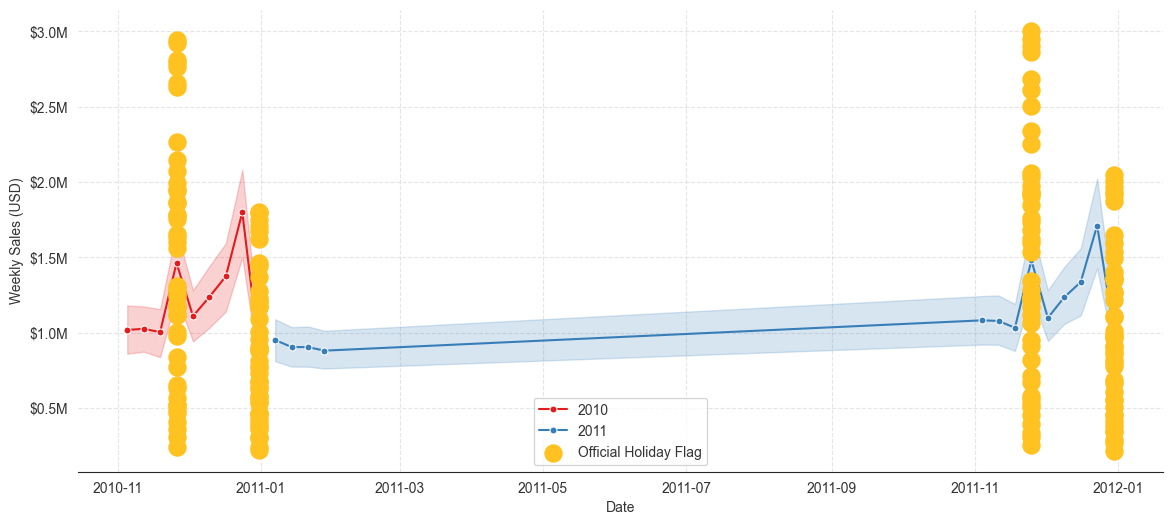

In [5]:
# Filter Data: Fokus ke Nov - Jan (High Season) untuk tahun 2010 & 2011
target_year = 2010
months = [11, 12, 1]

df_zoom = df[(df['Date'].dt.year.isin([target_year, target_year+1])) & 
             (df['Date'].dt.month.isin(months))].sort_values('Date')

plt.figure(figsize=(14, 6))

# Line Chart: Menunjukkan tren belanja asli
sns.lineplot(data=df_zoom, x='Date', y='Weekly_Sales', hue=df_zoom['Date'].dt.year.astype(str), 
             marker='o', markersize=5, palette='Set1')

# Scatter Plot: Menandai label 'Holiday' dari sistem
holidays = df_zoom[df_zoom['Holiday_Flag'] == 1]
plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color=GOLD_COLOR_WALMART, s=150, zorder=5, label='Official Holiday Flag')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

sns.despine(top=True, right=True, left=True)

# plt.title(f'Deteksi Anomali: Kapan Sebenarnya Customer Belanja? ({target_year}-{target_year+1})', fontsize=16)
plt.ylabel('Weekly Sales (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

Insight Bisnis:

- Thanksgiving: Label Holiday akurat. Penjualan meledak tepat di minggu liburan.

- Christmas: Ada anomali. Puncak belanja terjadi di Minggu 50 & 51 (Regular Week), sedangkan Minggu 52 (Holiday Week) penjualan justru jatuh. Jangan tertipu label holiday saat restock barang.

---


## 3. Menghitung "Stock Multiplier" (Angka Keramat)
Menghitung seberapa besar kita harus melipatgandakan stok di minggu puncak tersebut dibanding minggu biasa.

saya menggunakan median untuk menghindari lonjakan atau kekurangan stock 

In [6]:
# 1. Baseline: Rata-rata penjualan mingguan sepanjang tahun
# baseline_sales = df['Weekly_Sales'].mean()
baseline_sales = df[df['Event_Name'] == 'Regular Week']['Weekly_Sales'].median()

# 2. Peak Demand: Rata-rata penjualan di minggu "Pre-Christmas Rush" (Minggu 51)
pre_xmas_sales = df[(df['Date'].dt.isocalendar().week == 51)]['Weekly_Sales'].median()

# 3. Hitung Multiplier
multiplier = pre_xmas_sales / baseline_sales

print(f"=== REKOMENDASI STOK GUDANG ===")
print(f"Baseline Sales (Normal): ${baseline_sales:,.0f}")
print(f"Pre-Christmas Peak     : ${pre_xmas_sales:,.0f}")
print(f"STOCK MULTIPLIER       : {multiplier:.2f}x")
print(f"Kesimpulan: Tingkatkan kapasitas stok hingga {multiplier:.2f} kali lipat untuk minggu ke-50 & 51.")

=== REKOMENDASI STOK GUDANG ===
Baseline Sales (Normal): $956,211
Pre-Christmas Peak     : $1,619,180
STOCK MULTIPLIER       : 1.69x
Kesimpulan: Tingkatkan kapasitas stok hingga 1.69 kali lipat untuk minggu ke-50 & 51.


## 4. Segmentasi Toko (Pareto Analysis 80/60)
Menentukan toko mana saja yang layak mendapatkan prioritas stok 1.63x tersebut.

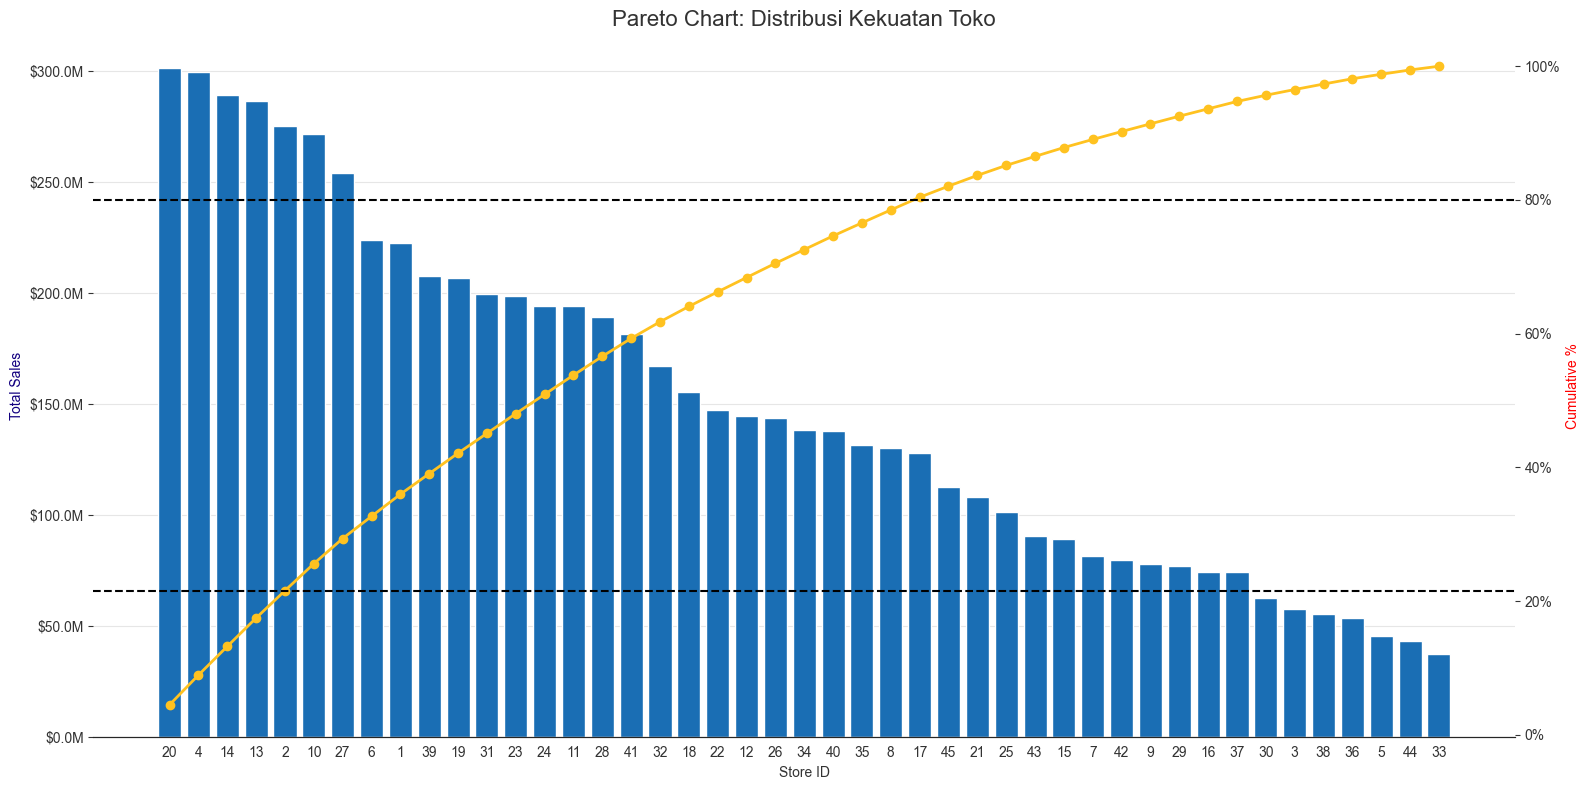

Hasil Analisis: 80% Omzet disumbang oleh 26 Toko teratas (dari total 45 toko).


In [7]:
# Siapkan Data Aggregat per Toko
store_perf = df.groupby('Store')['Weekly_Sales'].sum().reset_index()
store_perf = store_perf.sort_values('Weekly_Sales', ascending=False)

# Hitung Kumulatif
total_revenue = store_perf['Weekly_Sales'].sum()
store_perf['cumulative_percent'] = (store_perf['Weekly_Sales'].cumsum() / total_revenue) * 100
store_perf['Store'] = store_perf['Store'].astype(str) # Ubah jadi string untuk plotting

# Visualisasi Dual Axis (Pareto)
fig, ax = plt.subplots(figsize=(16, 8))

ax.grid(color='0.9')

# Bar Chart (Omzet Toko)
sns.barplot(data=store_perf, x='Store', y='Weekly_Sales', color=BLUE_COLOR_WALMART, alpha=1, ax=ax, order=store_perf['Store'])
ax.set_ylabel('Total Sales', color='#130080')
ax.set_xlabel('Store ID')

# Line Chart (% Kumulatif)
ax2 = ax.twinx()
ax2.plot(range(len(store_perf)), store_perf['cumulative_percent'], color=GOLD_COLOR_WALMART, marker='o', linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(80, color='black', linestyle='--', label='80% Threshold')
ax2.axhline(21.5, color='black', linestyle='--', label='80% Threshold')

# Format Sumbu Y menjadi Juta Dolar ($1.5M)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# Remove the right and top spines (borders)
sns.despine(left=True, bottom=False, top=True)

# Show the plot chart
plt.title('Pareto Chart: Distribusi Kekuatan Toko', fontsize=16)
plt.tight_layout()
plt.show()

# Hitung jumlah toko penyumbang 80%
top_stores = len(store_perf[store_perf['cumulative_percent'] <= 80])
print(f"Hasil Analisis: 80% Omzet disumbang oleh {top_stores} Toko teratas (dari total {len(store_perf)} toko).")

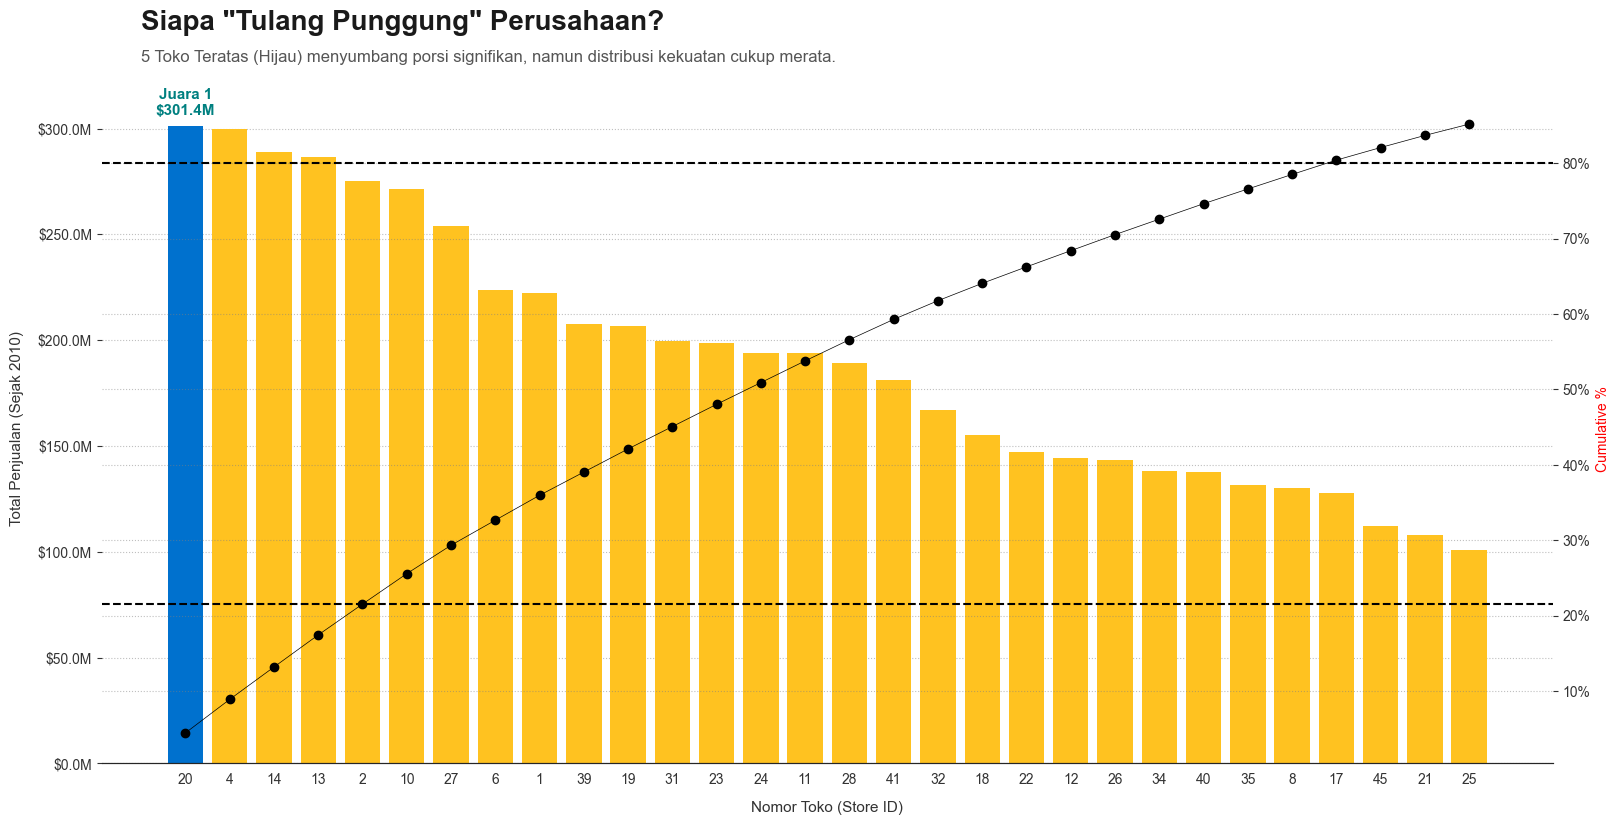

In [ ]:
# --- 1. SIAPKAN DATA ---
# (Asumsi dataframe 'store_perf' sudah ada dari kode sebelumnya)
# Kita ambil Top 30 saja agar grafik tidak terlalu padat di slide
top_30_stores = store_perf.head(30).copy()

# --- 2. COLOR STRATEGIS ---
# Kita buat list warna: Top 5 diberi warna "Teal Gelap" (Fokus), sisanya Abu-abu (Konteks)
colors = [BLUE_COLOR_WALMART if x < 1 else GOLD_COLOR_WALMART for x in range(len(top_30_stores))]

# --- 3. PLOTTING & CHART---
fig, ax = plt.subplots(figsize=(16, 8))
bars = ax.bar(top_30_stores['Store'], top_30_stores['Weekly_Sales'], edgecolor='none' , color=BLUE_COLOR_WALMART)

# --- 4. FORMATTING PROFESIONAL ---
# A. Format Sumbu Y menjadi Juta Dolar ($1.5M)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# B. Grid Horizontal Tipis (Bantu baca tapi tidak ganggu)
ax.grid(axis='y', linestyle=':', alpha=0.5, color='grey')
ax.set_axisbelow(True) # Pastikan grid di belakang batang

# C. Judul & Subjudul (Storytelling)
# Judul Utama (Bold, Besar)
props = dict(boxstyle='round', facecolor='none', alpha=0.5)
plt.text(x=-1, y=top_30_stores['Weekly_Sales'].max() * 1.15, 
         s='Siapa "Tulang Punggung" Perusahaan?', 
         fontsize=20, weight='bold', color='#1a1a1a', bbox=props)

# Subjudul (Deskriptif, Lebih Kecil)
plt.text(x=-1, y=top_30_stores['Weekly_Sales'].max() * 1.10, 
         s='5 Toko Teratas (Hijau) menyumbang porsi signifikan, namun distribusi kekuatan cukup merata.', 
         fontsize=12, color='#555555', bbox=props)

# D. Label Sumbu
plt.xlabel('Nomor Toko (Store ID)', fontsize=11, labelpad=10)
plt.ylabel('Total Penjualan (Sejak 2010)', fontsize=11, labelpad=10)

# E. Anotasi Langsung (Direct Labeling)
# Menambahkan label nilai hanya pada Juara 1 agar tidak semrawut
champion_sales = top_30_stores.iloc[0]['Weekly_Sales']
plt.text(x=0, y=champion_sales + 5000000, 
         s=f'Juara 1\n${champion_sales/1e6:.1f}M', 
         ha='center', fontsize=11, weight='bold', color='#008080')

# F. Line Chart (% Kumulatif)
ax2 = ax.twinx()
ax2.plot(range(len(top_30_stores)), top_30_stores['cumulative_percent'], color='black', marker='o', linewidth=0.5)
ax2.set_ylabel('Cumulative %', color='red')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(80, color='black', linestyle='--', label='80% Threshold')
ax2.axhline(21.5, color='black', linestyle='--', label='21.5% Threshold')

ax2.grid(axis='y', linestyle=':', alpha=0.5, color='grey')
ax2.set_axisbelow(True) 

# G. Hapus Border Atas dan Kanan (Despine)
sns.despine(left=True, bottom=False)

# Tamplikan Canvas Plot
plt.tight_layout(pad=0)
plt.show()

## Kesimpulan Akhir (Executive Summary)
Project ini mengubah cara pandang terhadap data musiman perusahaan:
- Strategi Waktu: Fokuskan logistik pada H-14 Natal, bukan pada minggu Natal itu sendiri.
- Strategi Alokasi: Terapkan Multiplier 1.64x terutama pada 27 Toko Utama yang menyumbang 80% pendapatan. Toko sisanya cukup gunakan stok standar untuk efisiensi biaya.

## Styling Canvas
I want to make sure our presentation will looks easy to read and increase visibility. It will make comfortable for the reader

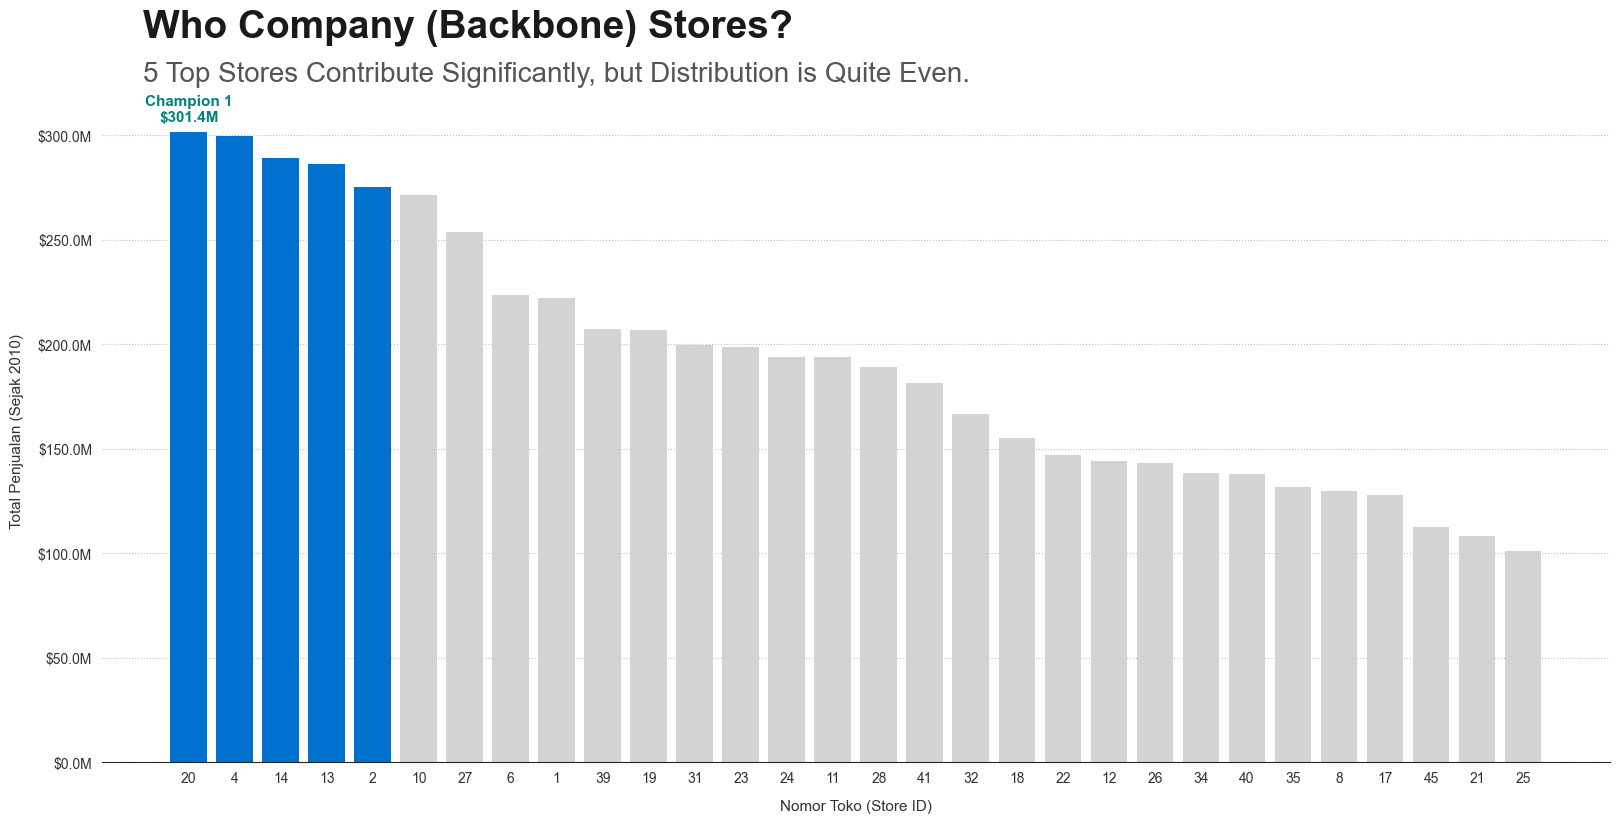

5 Stores Contributes in percent  21.54957119158127


In [11]:
# --- 1. COLOR STRATEGIS ---
# Kita buat list warna: Top 5 diberi warna "Teal Gelap" (Fokus), sisanya Abu-abu (Konteks)
colors = [BLUE_COLOR_WALMART if x < 5 else "#D3D3D3" for x in range(len(top_30_stores))]

# --- 2. PLOTTING & CHART ---
fig, ax = plt.subplots(figsize=(16, 8))
bars = ax.bar(top_30_stores['Store'], top_30_stores['Weekly_Sales'], color=colors, edgecolor='none')

# --- 3. FORMATTING PROFESIONAL ---
# A. Hapus Border Atas dan Kanan (Despine)
sns.despine(left=True, bottom=False)

# B. Format Sumbu Y menjadi Juta Dolar ($1.5M)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

# C. Grid Horizontal Tipis (Bantu baca tapi tidak ganggu)
ax.grid(axis='y', linestyle=':', alpha=0.5, color='grey')
ax.set_axisbelow(True) # Pastikan grid di belakang batang

# D. Judul & Subjudul (Storytelling)
# Judul Utama (Bold, Besar)
props = dict(boxstyle='round', facecolor='none', alpha=0.5)
plt.text(x=-1, y=top_30_stores['Weekly_Sales'].max() * 1.15, 
         s='Who Company (Backbone) Stores?', 
         fontsize=28, weight='bold', color='#1a1a1a', bbox=props)

# Subjudul (Deskriptif, Lebih Kecil)
plt.text(x=-1, y=top_30_stores['Weekly_Sales'].max() * 1.08, 
         s='5 Top Stores Contribute Significantly, but Distribution is Quite Even.', 
         fontsize=20, color='#555555', bbox=props)

# E. Label Sumbu
plt.xlabel('Nomor Toko (Store ID)', fontsize=11, labelpad=10)
plt.ylabel('Total Penjualan (Sejak 2010)', fontsize=11, labelpad=10)

# F. Anotasi Langsung (Direct Labeling)
# Menambahkan label nilai hanya pada sales bar tertinggi
champion_sales = top_30_stores.iloc[0]['Weekly_Sales']
plt.text(x=0, y=champion_sales + 5000000, 
         s=f'Champion 1\n${champion_sales/1e6:.1f}M', 
         ha='center', fontsize=11, weight='bold', color='#008080')

plt.tight_layout(pad=0)
plt.show()
print("5 Stores Contributes in percent ", top_30_stores[top_30_stores['Store'].isin(top_30_stores['Store'].head(5))]['Weekly_Sales'].sum() / df['Weekly_Sales'].sum() * 100)